# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Lab 03 - Bayesian Linear Regression

**Harvard University**<br>
**Spring 2024**<br>
**Instructors:** Pavlos Protopapas & Alex Young<br>

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

## Table of Contents

1. **Motivating Bayesian Regression**

1. **Bayesian Linear Regression: Known Variance**
    - Decide on likelihood function
    - Pick a prior
    - Compute likelihood for given data
    - Compute posterior
    - Conjugate update rule
    - Posterior predictive distribution
        - Analytic
        - Sampling

1. **Bayesian Linear Regression: Unknown Variance/Precision**

## 1. Intro & Motivation

### Linear Regression

Linear regression is a cornerstone of data science, offering a simple yet powerful way to model the linear relationship between a dependent variable and one or more independent variables. It's the go-to method for predictive modeling when the relationship between your variables is expected to be linear. In its simplest form, with one independent variable, the model predicts the dependent variable `Y` based on a linear combination of the independent variable `X` and an intercept term.

The equation of a simple linear regression model is:
$$
Y = \beta_0 + \beta_1x + \epsilon
$$
where $\beta_0$ is the intercept, $\beta_1$ is the slope coefficient, and $\epsilon$ represents the error term.


**Questions for Discussion**
- What's wrong with our old (frequentist) Linear Regression?
- But don't I already get uncertainty quantification with confidence intervals?
- Why is MLE prone to overfitting?
- But don't I have ways of addressing overfitting with the MLE approach?

### Frequentist Paradigm

In the frequentist paradigm, we often use Maximum Likelihood Estimation (**MLE**) to find the best-fitting parameters (`β`) that minimize the squared difference between the predicted and observed values. MLE provides **point estimates** for these parameters, aiming for the most likely values given the observed data.

However, MLE does not directly offer a measure of uncertainty in these estimates beyond confidence intervals derived from assumptions about the error distribution. It also doesn't naturally incorporate prior knowledge about the parameters, which can be critical in cases of limited data or when we have strong reasons to believe parameters should have certain values based on previous research or theoretical considerations.


### Advantages of the Bayesian Approach

The Bayesian approach to linear regression provides a probabilistic perspective, offering not just estimates of the regression coefficients but a full distribution of possible values. This distribution reflects our uncertainty about the coefficients, incorporating both the data (likelihood) and our prior beliefs (prior distribution).

One key advantage of this method is its ability to update our beliefs about the model parameters in light of new data, a process known as Bayesian updating. Additionally, the Bayesian framework naturally incorporates prior knowledge, allowing for more informed and potentially more accurate estimates, especially in situations where data are scarce or noisy.


## 2. Bayesian Linear Regression (with Known Noise Variance)

For our Bayesian linear regression model, we'll simplify the scenario by assuming that the noise variance (`σ²`) is known. This assumption allows us to focus on learning the regression coefficients using a **Normal-Normal conjugate model**. Recall that a 'conjugate' prior is a prior chosen such that the posterior distribution is the same type as the prior, simplifying calculations significantly.

In our case, we'll assume Normal priors for our coefficients (`β`), which, combined with a Normal likelihood function (due to the assumption of normally distributed errors), ensures that our posterior distributions for the coefficients are also Normal!

#### Bayesian Linear Regression with Multiple Coefficients

In cases where our linear regression model includes multiple coefficients, such as an intercept $\beta_0$ and slope $\beta_1$, we extend our approach to accommodate the multivariate nature of our parameters. This involves adopting a multivariate normal distribution for both the prior and posterior distributions of the coefficients. Here, the mean of the distribution, $\mu$, becomes a vector, and the variance is represented by a covariance matrix, $\Sigma$, which captures the variances and covariances of the coefficients.

Here is some synthetic data we can attempt to model using Bayesian Linear regression.

In [2]:
np.random.seed(42)  # For reproducibility

# Simulate data
N = 100
x = np.random.uniform(-1.5, 1.5, N) # Predictor
b0 = -0.75  # True intercept
b1 = 0.65  # True slope
sigma2 = 1 # Known noise variance
epsilon = np.random.normal(0, np.sqrt(sigma2), N).reshape(-1,1)

# Generate exam scores
y = b0 + b1 * x + epsilon

# Alternatively, using the augmented design matrix X
# and the vector of regression coefficients, beta
X = np.vstack([np.ones_like(x), x]).T # add column of ones
beta = np.array([b0, b1]).reshape(-1,1) # column vector of coeffs
y = X@beta + epsilon

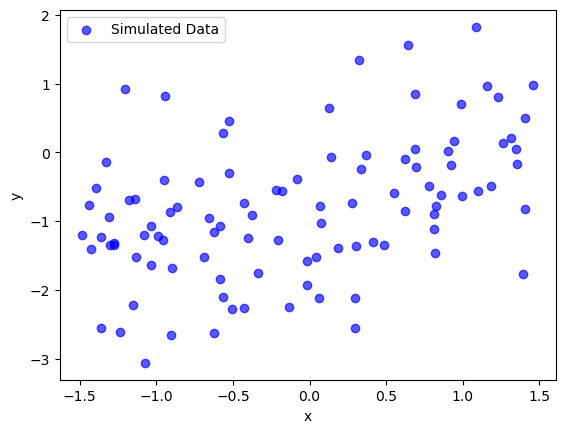

In [3]:
# Viz synthetic data
plt.scatter(X[:,1], y, alpha=0.65, color='blue', label='Simulated Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Procedure Summary


**Step 1: Likelihood function**

An assumption of linear regression is that the response, $y$, is equal to some linear combination of predictors plus an intercept and a normally distributed noise term.

$$ Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_{p-1} x_{p-1} + \beta_p x_p + \epsilon$$
Where $\epsilon$ is the irriducible error, or 'noise' term, $\epsilon \sim N(0,\sigma^2)$

We can write this more compactly by adding a column of ones to our design matrix, $X$, and putting the intercept, $\beta_0$, along with all the other regression coefficients in the column vector, $\beta$.

$$ \vec{Y} = \mathbf{X\beta} + \epsilon$$

This is equivalent to the formulation:


$$Y|x, \beta \sim N(x^T\beta, \sigma^2) $$

And so

$$E[Y|x,\beta] = x^T\beta$$

**Step 2: Assume a prior distribution for the parameters**

We need to choose a prior distribution for $\mathbf{\beta}$ before we get started, here we assume a multivariate normal distribution (conjugate!):

$$\mathbf{\beta} \sim N(\vec{m}_0, \Sigma_0)$$


Initially, we can choose $\vec{m}_0 = \vec{\mathbf{0}}$ and $\Sigma_0 = \alpha ^2I$

(this ensures that the covariance matrix is diagonal with non-negative entries)

**Step 3: Compute the likelihood from the joint probability of the data, viewed as a function of the unknown parameters**

Assume we have $n$ data pairs: $D = \{(\mathbf{x}^{(1)}, y^{(1)}), ..., (\mathbf{x}^{(n)}, y^{(n)}) \}$

The likelihood of the parameter $\mathbf{\beta}$ is

$$L(\mathbf{\beta} | D) = \prod_{i=1}^n P(y^{(i)} | \mathbf{x}^{(i)}, \mathbf{\beta})$$

In [ ]:
# potential exercise: comparing the PDF to the likelihood function



**Step 4: Obtain the posterior density via Bayes rule**

#### The Multivariate Bayesian Update

For multiple regression coefficients, the prior distribution of $\boldsymbol{\beta} = [\beta_0, \beta_1, \dots, \beta_n]^T$ is a multivariate normal distribution, expressed as $N(\boldsymbol{\mu}, \boldsymbol{\Sigma})$, where:

- $\boldsymbol{\mu}$ is the vector of prior means for the coefficients.
- $\boldsymbol{\Sigma}$ is the covariance matrix representing the variances and covariances of the coefficients.

Given a design matrix $X$ and a vector of outcomes $Y$, the likelihood of observing $Y$ given $X$ and $\boldsymbol{\beta}$ is normally distributed. The goal is to update our beliefs about $\boldsymbol{\beta}$ given the observed data.


**Step 5: Analyze the posterior distribution if possible**

Often you'd like to summarize the posterior by looking at the expected value, variance, etc.

This is easy when using a conjugate prior as the posterior belongs to the same family as the prior and we have closed form expressions for these values for named distribution families.

**Step 6: Deriving the Posterior Distribution**

The posterior distribution of $\boldsymbol{\beta}$, given the data $Y$, is also a multivariate normal distribution $N(\boldsymbol{\mu_{post}}, \boldsymbol{\Sigma_{post}})$. The parameters of this posterior distribution can be updated using the following formulas:

$$
\boldsymbol{\Sigma_{post}} = \left(\boldsymbol{\Sigma}^{-1} + \frac{X^TX}{\sigma^2}\right)^{-1}
$$

$$
\boldsymbol{\mu_{post}} = \boldsymbol{\Sigma_{post}} \left(\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu} + \frac{X^TY}{\sigma^2}\right)
$$

where $\sigma^2$ is the known variance of the noise in the outcome $Y$.


In [ ]:
# Prior mean vector and covariance matrix for the coefficients
p = X.shape[1]-1
mu_prior = np.zeros(p+1).reshape(-1,1)  # Adjust based on your prior knowledge
a = 3
Sigma_prior = a**2*np.eye(p+1)  # Identity matrix for simplicity, adjust as needed

#### Exercise:
Use the update rules above to complete the function below

In [ ]:
def update_posterior(X, y, sigma2, mu_prior, Sigma_prior):
    """
    Correctly updates the posterior mean and covariance matrix for a Bayesian linear regression model.

    Parameters:
    - X: Design matrix (or vector) of predictors. Should be 2D (n, p) for full data or 1D (p,) for a single observation.
    - y: Vector of outcomes. Should be 1D (n,) for full data or a scalar for a single observation.
    - sigma2: Known variance of the noise in the outcomes.
    - mu_prior: Prior (or most recent posterior) mean vector of the regression coefficients.
    - Sigma_prior: Prior (or most recent posterior) covariance matrix of the regression coefficients.

    Returns:
    - mu_post: Updated posterior mean vector of the regression coefficients.
    - Sigma_post: Updated posterior covariance matrix of the regression coefficients.
    """
    # Reshape X and Y for single observations
    X = np.atleast_2d(X)  # Ensures X is 2D even for a single observation
    y = np.atleast_1d(y)  # Ensures Y is 1D even for a scalar

    # Calculate updates... mind the shape of arrays!!
    Sigma_post = ...
    mu_prior_reshaped = ...

    return mu_post, Sigma_post

These are our posterior parameters after observing all the data.

In [ ]:
mu_post, Sigma_post = update_posterior(X, y, sigma2, mu_prior, Sigma_prior)

print("Posterior Mean:", mu_post)
print("Posterior Covariance Matrix:\n", Sigma_post)

This function will compute a sequence of posterior parameters derived from viewing chunks of data.

In [ ]:
def accumulate_posterior_distributions(X, y, sigma2, mu_prior, Sigma_prior, update_every=5):
    """
    Accumulate parameters of posterior distributions after observing every 'update_every' data points.
    
    Parameters:
    - X: Design matrix with observations as rows and features as columns.
    - y: Vector of outcomes corresponding to each row in X.
    - sigma2: Known variance of the noise in the outcomes.
    - mu_prior: Initial prior mean vector for the regression coefficients.
    - Sigma_prior: Initial prior covariance matrix for the regression coefficients.
    - update_every: Number of new observations after which to update the posterior.
    
    Returns:
    - A list of tuples, each containing the mean vector and covariance matrix of the original prior
      followed by those of the new posterior distribution at each update interval.
    """
    n_points = len(y)
    posterior_params = [(mu_prior.flatten(), Sigma_prior)]
    
    for i in range(0, n_points, update_every):
        X_current = X[:i + update_every]
        y_current = y[:i + update_every]
        mu_post, Sigma_post = update_posterior(X_current, y_current, sigma2, mu_prior, Sigma_prior)
        
        # Store the parameters of the current posterior distribution
        posterior_params.append((mu_post.flatten(), Sigma_post))
        
        # Update mu_prior and Sigma_prior for the next iteration
        mu_prior, Sigma_prior = mu_post, Sigma_post
    
    return posterior_params

In [ ]:
posterior_params = accumulate_posterior_distributions(X, y, sigma2, mu_prior, Sigma_prior, update_every=1)

mu_post = posterior_params[-1][0]
Sigma_post = posterior_params[-1][1]
print("Posterior Mean:", mu_post)
print("Posterior Covariance Matrix:\n", Sigma_post)

### Visualize Evolution of Regression Line

In [ ]:
def plot_regression_updates(X, y, sigma2, mu_prior, Sigma_prior, update_every=5):
    """
    Plot regression line updates after observing every 'update_every' data points, incorporating the latest
    `update_posterior` implementation. Each subplot shows the regression line based on the data observed so far,
    with new data points highlighted.
    
    Parameters are as described in the original function.
    """
    n_points = len(y)
    n_updates = n_points // update_every

    # Calculate grid size for subplots to not exceed 5 columns
    n_rows = int(np.ceil(n_updates / 5))
    n_cols = min(n_updates, 5)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), squeeze=False)
    axes = axes.flatten()

    for i in range(n_updates):
        X_current = X[:(i+1)*update_every]
        y_current = y[:(i+1)*update_every]
        mu_post, Sigma_post = update_posterior(X_current, y_current, sigma2, mu_prior, Sigma_prior)

    # Plot all data points observed so far
        axes[i].scatter(X_current[:, 1], y_current, color='blue', label='Previous Points')
        if i < n_updates - 1:
            # Highlight new points in a different color
            axes[i].scatter(X[(i*update_every):(i+1)*update_every, 1], y[(i*update_every):(i+1)*update_every], color='red', label='New Points')

        # Calculate and plot the regression line
        x_line = np.linspace(X[:,1].min(), X[:,1].max(), 100)
        X_line = np.vstack([np.ones_like(x_line), x_line]).T # add column of ones
        y_line = X_line@mu_post
        axes[i].plot(x_line, y_line, color='black', label='Regression Line')

        axes[i].legend()
        axes[i].set_xlabel('X')
        axes[i].set_title(f'{(i+1)*update_every} Data Points')

    axes[0].set_ylabel('y')

    # Ensure axes not used are hidden, for cases where n_updates < n_rows * n_cols
    for j in range(n_updates, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
plot_regression_updates(X, y, sigma2, mu_prior, Sigma_prior, update_every=5)

## Visualizing of Evolution of Posterior

Visualizing the posterior distributions of the coefficients can provide deeper insights into the relationships between predictors and the response variable. For two coefficients, consider plotting contour lines representing the joint posterior distribution, which can illustrate not only the individual uncertainties but also how the coefficients might co-vary.


In [ ]:
def plot_posterior(coef_dist):
    fig, axs = plt.subplots(4, 5, figsize=(27, 20))
    x, y = np.mgrid[-1.5:1:.01, -1:1.5:.01]
    pos = np.dstack((x, y))
    fig.suptitle("Updating of Posterior Distribution")
    for i in range(min([20, len(coef_dist)])):
        rv = coef_dist[i]
        im = axs[i//5][i%5].contourf(x, y, rv.pdf(pos))
        axs[i//5][i%5].set_title(f"{i*5} data points")
        axs[i//5][i%5].set_xlabel("$\\beta_0$")
        axs[i//5][i%5].set_ylabel("$\\beta_1$")
    cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    lines = axs[-1][-1].get_legend_handles_labels()[0]
    labels = axs[-1][-1].get_legend_handles_labels()[1]
    # fig.legend(lines, labels, loc='upper right')

coef_dists = [multivariate_normal(mu, cov) for (mu, cov) in posterior_params]
plot_posterior(coef_dists)

## Understanding the Posterior Predictive Distribution

The posterior predictive distribution represents our predictions for new, unseen data points, incorporating all the knowledge we've accumulated from the observed data. It is derived by integrating the joint probability of the new data point and the parameters over the entire posterior distribution of the parameters. This process effectively averages predictions over all possible parameter values, weighted by their posterior probability.

### The Posterior Predictive Distribution as a Marginal Distribution

Given:
- Observed data $Y$ and predictors $X$.
- New predictors $X_{\text{new}}$ for which we want to predict the corresponding $Y_{\text{new}}$.

The posterior predictive distribution for $Y_{\text{new}}$ given $X_{\text{new}}$ and observed data $(X, Y)$ is calculated by marginalizing over the posterior distribution of the parameters $\beta$:

$$
p(Y_{\text{new}} | X_{\text{new}}, X, Y) = \int p(Y_{\text{new}} | X_{\text{new}}, \beta) p(\beta | X, Y) d\beta
$$

- $p(Y_{\text{new}} | X_{\text{new}}, \beta)$ is the likelihood of observing $Y_{\text{new}}$ given $X_{\text{new}}$ and parameters $\beta$.
- $p(\beta | X, Y)$ is the posterior distribution of $\beta$ given the observed data.

### Analytic Derivation for Normal-Normal Model

In the context of Bayesian linear regression with a normal likelihood and a normal prior on $\beta$ (the normal-normal model):

- Likelihood: $Y | X, \beta \sim \mathcal{N}(X^T\beta, \sigma^2)$
- Prior: $\beta \sim \mathcal{N}(\mu_0, \Sigma_0)$
- Posterior of $\beta$: Given the conjugacy, $\beta | X, Y \sim \mathcal{N}(\mu_{\text{post}}, \Sigma_{\text{post}})$

The posterior predictive distribution for $Y_{\text{new}}$ is then also normally distributed, with mean and variance derived from the formula above:

$$
Y_{\text{new}} | X_{\text{new}}, X, Y \sim \mathcal{N}(X_{\text{new}}^T \mu_{\text{post}}, \sigma^2 + X_{\text{new}}^T \Sigma_{\text{post}} X_{\text{new}})
$$

### Intuition and Summary

The posterior predictive distribution integrates out the uncertainty in the parameters $\beta$, providing a predictive distribution that accounts for both the aleatoric uncertainty (inherent data noise) and epistemic uncertainty (parameter uncertainty). This results in a comprehensive predictive distribution that reflects all sources of uncertainty in our model.


In [ ]:
# Assuming mu_post, Sigma_post, and sigma2 are defined from your Bayesian linear regression model
# mu_post: Posterior mean vector of the regression coefficients
# Sigma_post: Posterior covariance matrix of the regression coefficients
# sigma2: Known variance of the noise in the outcomes

# Example new predictors X_new
x_line = np.linspace(X[:,1].min(), X[:,1].max(), 100)
X_new = np.vstack([np.ones_like(x_line), x_line]).T # add column of ones and squared term

# Calculate mean and variance of the posterior predictive distribution for each new data point
mu_post = posterior_params[-1][0]
Sigma_post = posterior_params[-1][1]
post_pred_mean = X_new @ mu_post  # Mean of the posterior predictive distribution

# For the variance, we need to calculate X_new^T Sigma_post X_new for each data point, plus sigma2
post_pred_var = np.array([x_new @ Sigma_post @ x_new.T for x_new in X_new]) + sigma2

# Generate predictions from the posterior predictive distribution
# Here we draw one sample for each new data point to illustrate, you could draw more samples if needed
predictions = np.random.normal(post_pred_mean, np.sqrt(post_pred_var))

In [ ]:
plt.scatter(X[:,1], y, label='original data')
plt.scatter(X_new[:,1], predictions, label='simulated data (analytic)')
plt.legend()
plt.xlabel('x')
plt.ylabel('y');

## Multi-Step Monte Carlo Simulation for Posterior Predictive Sampling

As an alternative to the analytic posterior predictive distribution, we can use a Monte Carlo simulation to generate samples. This approach is especially useful in complex models or when an analytic solution is not straightforward.

### Steps

1. **Sample $\beta$**: Draw $M$ samples $\{\beta^{(m)}\}_{m=1}^M$ from the posterior distribution of $\beta$, $\beta | Y \sim \mathcal{N}(\mu_{\text{post}}, \Sigma_{\text{post}})$.

2. **Generate Predictive Samples**: For each sampled $\beta^{(m)}$, generate a predictive sample for a new observation $Y_{\text{new}}^{(m)}$ using $X_{\text{new}}$:
    - Compute the mean $X_{\text{new}}^T \beta^{(m)}$.
    - Draw $Y_{\text{new}}^{(m)}$ from $\mathcal{N}(X_{\text{new}}^T \beta^{(m)}, \sigma^2)$.

3. **Analysis**: The collection $\{Y_{\text{new}}^{(m)}\}_{m=1}^M$ represents samples from the posterior predictive distribution. Analyze these samples to estimate predictive means, intervals, or other quantities of interest.

### Implementation
This Monte Carlo approach can be implemented using numerical libraries such as NumPy for sampling and matrix operations, and SciPy for working with distributions. It offers a practical alternative to the analytic derivation, providing a computational method to explore the posterior predictive distribution.


In [ ]:
import numpy as np
import scipy.stats as stats

# Number of samples to draw from the posterior distribution of beta
n_samples = 1000

# Sample a beta vector from its posterior distribution for each x_new
beta_samples = np.random.multivariate_normal(mu_post, Sigma_post, n_samples)

# Initialize an array to store predictive sample for each X_new
predictive_samples = np.zeros([X_new.shape[0], n_samples])

# For each sampled beta, generate predictive samples
for i, beta in enumerate(beta_samples):
    # Compute predictive mean for new data points
    predictive_mean = X_new @ beta
    # Sample from the normal distribution with the computed mean and known variance sigma2
    predictive_samples[:, i] = np.random.normal(predictive_mean, np.sqrt(sigma2))

# Calculate mean and percentile intervals (e.g., 95% CI) for the predictive samples
predictive_mean = np.mean(predictive_samples, axis=1)
lower_percentile = np.percentile(predictive_samples, 2.5, axis=1)
upper_percentile = np.percentile(predictive_samples, 97.5, axis=1)

In [ ]:
beta_samples = np.random.multivariate_normal(mu_post, Sigma_post, X_new.shape[0])
predictive_samples = np.zeros((X_new.shape[0]))
for i, beta in enumerate(beta_samples):
    # Compute predictive mean for new data points
    predictive_mean = X_new[i] @ beta
    # Sample from the normal distribution with the computed mean and known variance sigma2
    predictive_samples[i] = np.random.normal(predictive_mean, np.sqrt(sigma2))

In [ ]:
import numpy as np
import scipy.stats as stats

# Number of samples to draw from the posterior distribution of beta
n_samples = 1000

# Sample beta from its posterior distribution
beta_samples = np.random.multivariate_normal(mu_post, Sigma_post, n_samples)

# Initialize an array to store predictive samples for each X_new
predictive_samples = np.zeros((X_new.shape[0], n_samples))

# For each sampled beta, generate predictive samples
for i, beta in enumerate(beta_samples):
    # Compute predictive mean for new data points
    predictive_mean = X_new @ beta
    # Sample from the normal distribution with the computed mean and known variance sigma2
    predictive_samples[:, i] = np.random.normal(predictive_mean, np.sqrt(sigma2))

# Calculate mean and percentile intervals (e.g., 95% CI) for the predictive samples
predictive_mean = np.mean(predictive_samples, axis=1)
lower_percentile = np.percentile(predictive_samples, 2.5, axis=1)
upper_percentile = np.percentile(predictive_samples, 97.5, axis=1)

# Example plotting the mean prediction and confidence intervals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(x_line, predictive_mean, label='Predictive Mean')
plt.fill_between(x_line, lower_percentile, upper_percentile, color='gray', alpha=0.5, label='95% Predictive Interval')
plt.scatter(X[:, 1], y, color='red', s=10, label='Observed Data')  # Assuming Y are the observed responses
plt.xlabel('Predictor')
plt.ylabel('Response')
plt.legend()
plt.title('Posterior Predictive Distribution with 95% Predictive Interval')
plt.show()


## 3. Bayesian Linear Regression with Unknown Noise Variance

In the Bayesian framework, when both the regression coefficients and the noise variance are unknown, a common approach is to use a Normal-Gamma conjugate prior. This model assumes:

- The likelihood of observing data $Y$ given predictors $X$ and parameters $\beta$ and $\sigma^2$ is $Y | X, \beta, \sigma^2 \sim \mathcal{N}(X\beta, \sigma^2I)$.
- The prior over $\beta$ is a multivariate normal distribution, $\beta \sim \mathcal{N}(\mu_0, \sigma^2 \Lambda_0^{-1})$, where $\mu_0$ is the prior mean and $\Lambda_0$ is the precision matrix (inverse of the covariance matrix) scaled by $\sigma^2$.
- The prior over the precision $\tau$ (inverse of the variance $\sigma^2$) follows a Gamma distribution, $\tau \sim \text{Gamma}(\alpha_0, \beta_0)$, where $\alpha_0$ and $\beta_0$ are the shape and rate parameters of the Gamma distribution, respectively.

The Normal-Gamma conjugate prior allows for an analytical solution to the posterior distributions of $\beta$ and $\tau$, incorporating all information from the data and the prior beliefs about the parameters.

### Deriving the Posterior Distributions

Given new data $(X, Y)$, the posterior distributions for $\beta$ and $\tau$ can be analytically derived, leading to:

- The posterior distribution of $\beta$ given $\tau$ and data is a multivariate normal distribution with updated mean $\mu_{\text{post}}$ and precision matrix $\Lambda_{\text{post}}$.
- The posterior distribution of $\tau$ is a Gamma distribution with updated shape $\alpha_{\text{post}}$ and rate $\beta_{\text{post}}$.

These posterior distributions incorporate the evidence from the data, updating our beliefs about the regression coefficients and the noise variance.


### Prior Specification

In this Bayesian linear regression model with unknown precision, we specify our priors as follows to ensure conjugacy:

- **Coefficients Prior**: For the regression coefficients β, given the precision τ, we use a multivariate normal distribution: $$\beta | \tau \sim \mathcal{N}(\mu_0, (\tau \Lambda_0)^{-1})$$ where $\mu_0$ is the prior mean vector and $\Lambda_0$ is the prior precision matrix for β.

- **Precision Prior**: For the precision of the noise, we use a Gamma distribution: $$\tau \sim \Gamma(\alpha_0, \beta_0)$$ where $\alpha_0$ is the shape parameter and $\beta_0$ is the rate parameter of the Gamma distribution.


### Posterior Update Rules for Bayesian Linear Regression with Unknown Precision

After observing the data \(Y\), we update our beliefs about the regression coefficients (\(\beta\)) and the precision (\(\tau\)), employing Bayesian inference. The update rules for the posterior distributions, given our Normal-Gamma conjugate prior setup, are as follows:

1. **Posterior Distribution of Regression Coefficients ($\beta$)**:
   The posterior distribution of \(\beta\), given \(\tau\) and the data \(Y\), follows a Multivariate Normal distribution. The update rules for the parameters of this distribution are derived from the conjugate prior relationship, leading to:
   - **Posterior Mean ($\beta_N$)**: 
     $$ \beta_N = \Lambda_N^{-1} (X^TY + \Lambda_0 \beta_0) $$
   - **Precision Matrix ($\Lambda_N$)**: 
     $$ \Lambda_N = \Lambda_0 + X^TX $$

2. **Posterior Distribution of Precision ($\tau$)**:
   The posterior distribution of \(\tau\), after observing the data \(Y\), follows a Gamma distribution. The update rules for the Gamma distribution parameters are:
   - **Shape Parameter ($a_N$)**: 
     $$ a_N = a + \frac{N}{2} $$
   - **Rate Parameter ($b_N$)**: 
     $$ b_N = b + \frac{1}{2} \left( Y^TY + \beta_0^T\Lambda_0\beta_0 - \beta_N^T\Lambda_N\beta_N \right) $$

These update rules allow us to analytically determine the posterior distributions of \(\beta\) and \(\tau\), reflecting our updated beliefs based on the observed data.


### Analytic Posterior Predictive Distribution

The posterior predictive distribution for a new observation $x_{new}$ can be analytically derived under the Gaussian noise model. Given the conjugate Normal-Gamma prior and the linear model assumptions, the predictive distribution for a new observation $y_{new}$, given new data $x_{new}$, is:

$$y_{new} | x_{new}, X, y \sim t_{2\alpha_n} \left( x_{new}^T \mu_n, \frac{\beta_n}{\alpha_n} \left(1 + x_{new}^T (\Lambda_n)^{-1} x_{new} \right) \right)$$

This distribution is a non-standardized Student's t-distribution, indicating the predictive uncertainty in $y_{new}$.


### Sampling Approach to Posterior Predictive

Though we have an analytic form for the posterior predictive distribution, sampling provides an alternative approach that is often easier to implement and interpret, especially in more complex models or for extensive posterior analysis. Here, we demonstrate how to perform this sampling using NumPy.

1. Draw samples of τ from its posterior Gamma distribution.
2. Given each sampled τ, draw β from its conditional posterior multivariate normal distribution.
3. Use the sampled β and τ to draw samples from the predictive distribution for new observations.


In [ ]:
# Prior parameters
a = 2.0  # Shape parameter for Gamma prior on τ
b = 2.0  # Rate parameter for Gamma prior on τ
Lambda_0 = np.eye(2)  # Prior precision matrix for β
beta_0 = np.zeros(2)  # Prior mean for β

In [ ]:
# Update rules to calculate posterior parameters
y = y.flatten()
Lambda_N = Lambda_0 + X.T @ X
beta_N = np.linalg.inv(Lambda_N) @ (X.T @ y + Lambda_0 @ beta_0)
a_N = a + N / 2
b_N = b + 0.5 * (y.T@y + beta_0.T @ Lambda_0 @ beta_0 - beta_N.T @ Lambda_N @ beta_N)

In [ ]:
beta_N

In [ ]:
# Sampling from the posterior distributions
n_samples = 1000
tau_samples = np.random.gamma(a_N, 1 / b_N, n_samples)  # Sampling τ from its posterior Gamma distribution
beta_samples = [np.random.multivariate_normal(beta_N, np.linalg.inv(tau * Lambda_N)) for tau in tau_samples]

# To store samples from the posterior predictive distribution for new observations X_new
predictive_samples = np.zeros((X_new.shape[0], n_samples))

# For each sampled tau and beta, generate predictive samples
for i, (tau, beta) in enumerate(zip(tau_samples, beta_samples)):
    # Compute predictive mean for new data points
    predictive_mean = X_new @ beta
    # Sample from the normal distribution with the computed mean and precision
    predictive_samples[:, i] = np.random.normal(X_new @ beta, 1 / np.sqrt(tau))


In [ ]:
plt.scatter(X[:,1], y, label='original data')
plt.scatter(X_new[:,1], predictive_samples[:,1], label='simulated data (simulated)')
plt.legend()
plt.xlabel('x')
plt.ylabel('y');